# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

***

### Import Packages

In [127]:
# standard library imports
import glob
import math
import os
import re
import shutil

# related third party imports
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # unused
from moviepy.editor import VideoFileClip
import numpy as np

# output of plotting commands is displayed inline within Jupyter notebook
%matplotlib inline

### Helper functions

In [128]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

### Camera calibration

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


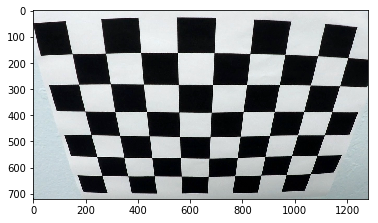

In [129]:
image = cv2.imread('camera_cal/calibration2.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [130]:
# prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(7,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = sorted_alphanumeric(glob.glob('camera_cal/calibration*.jpg'))

# Prepare output directory
if not os.path.exists('output_images/camera_cal'):
            os.makedirs('output_images/camera_cal')
print(images)
        
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        write_name = f'output_images/camera_cal/corners_found{str(idx+1)}.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
cv2.destroyAllWindows()

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration20.jpg']


Text(0.5,1,'Chessboard Corners')

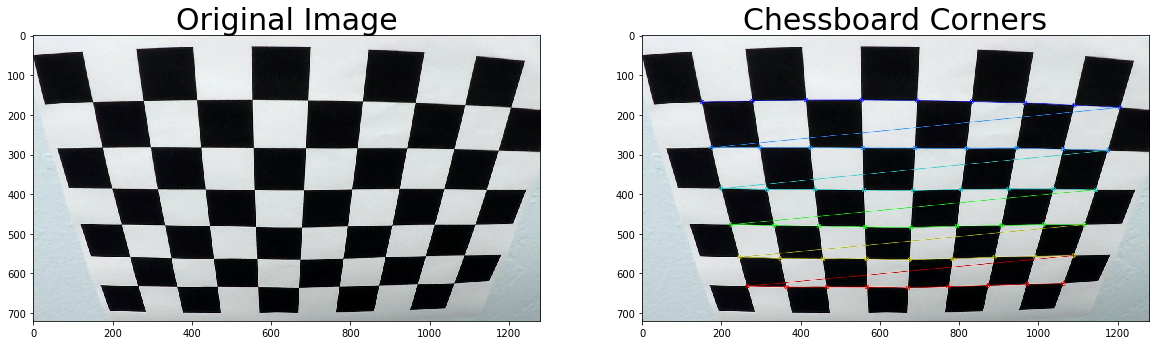

In [132]:
# Visualize chessboard corners
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration2.jpg'))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.imread('output_images/camera_cal/corners_found2.jpg'))
ax2.set_title('Chessboard Corners', fontsize=30)

### Undistortion

In [133]:
img_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Prepare output directory
if not os.path.exists('output_images/undistortion'):
            os.makedirs('output_images/undistortion')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    write_name = f'output_images/undistortion/undistorted{str(idx+1)}.jpg'
    cv2.imwrite(write_name, dst)

Text(0.5,1,'Undistorted Image')

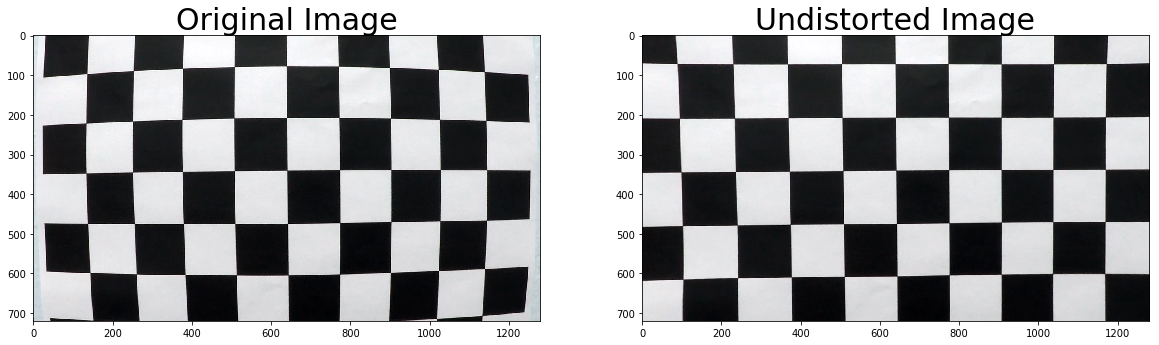

In [134]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread('camera_cal/calibration1.jpg'))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.imread('output_images/undistortion/undistorted1.jpg'))
ax2.set_title('Undistorted Image', fontsize=30)